In [2]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import torch

torch.set_float32_matmul_precision("medium")  # Try "high" as well

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger
import mlflow
from typing import Tuple, List
import numpy as np

import coremltools as ct

import sys

try:
    import src
except:
    sys.path.append('../')
    import src

from src.dataset import SimpleWallADE20KDataset
from src.model import WallModel
from src import config
from src.transform import get_preprocessing_transform, get_train_augmentations, get_val_augmentations

In [7]:
TRAIN_SIZE = 10
VAL_SIZE = 10

# TODO: add option to not enforce specific image size, just pad to a multiple of 32,
#   as it was done for image segmentation sample
#   But first check if CoreML supports dynamic input size
train_augmentations = get_train_augmentations()
train_dataset = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    mode='train',
    length=TRAIN_SIZE,
    augmentation_fn=train_augmentations,
    preprocessing_fn=None
)

val_augmentations = get_val_augmentations()
val_dataset = SimpleWallADE20KDataset(
    root=config.DATA_ROOT,
    mode='val',
    length=TRAIN_SIZE,
    augmentation_fn=val_augmentations,
    preprocessing_fn=None
)

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

n_cpu = os.cpu_count()
print(f'Number of CPUs: {n_cpu}')
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=n_cpu)

Train size: 10
Validation size: 10
Number of CPUs: 20


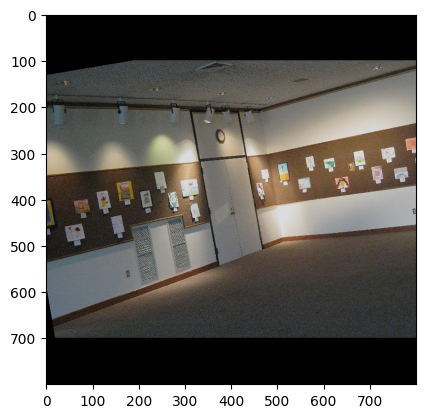

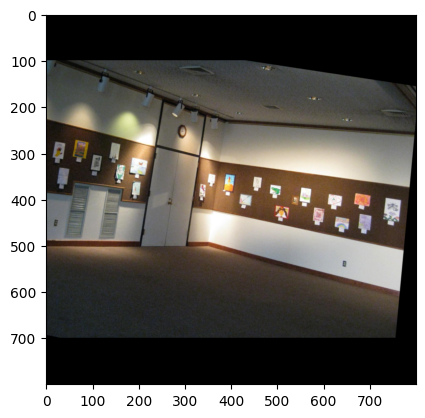

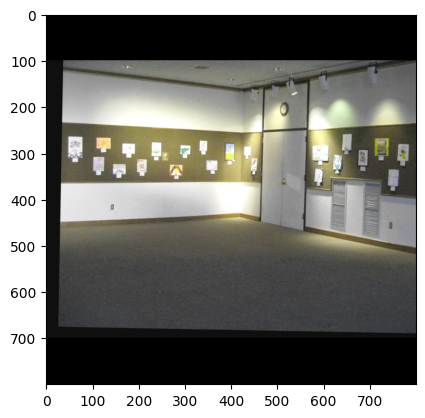

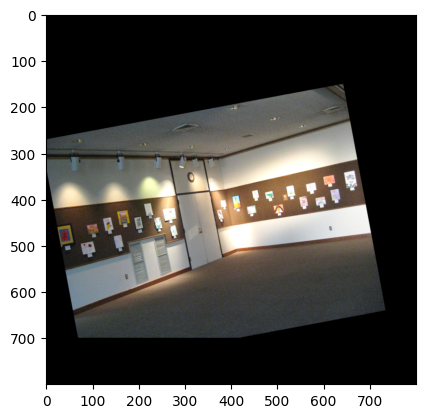

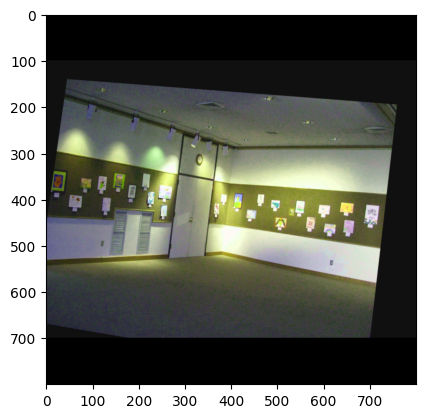

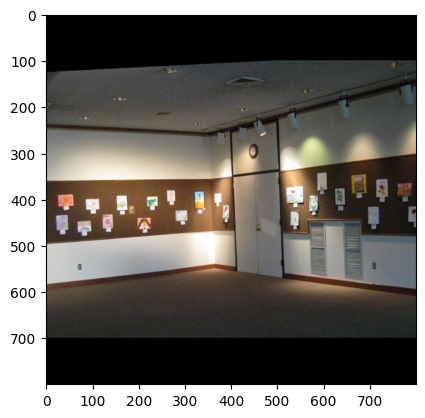

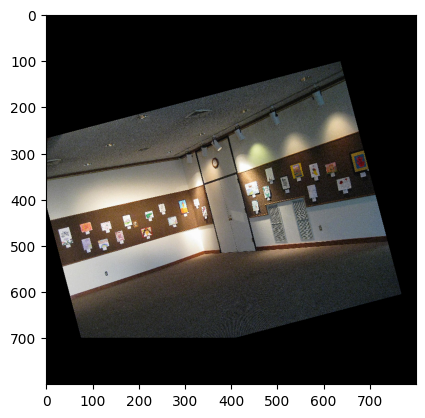

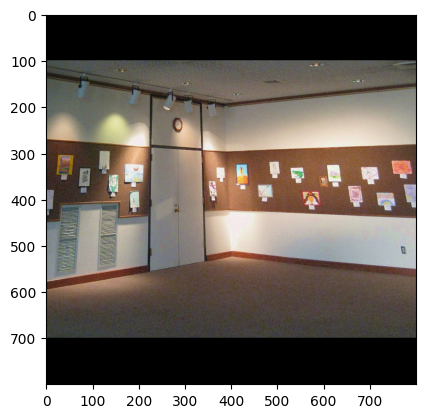

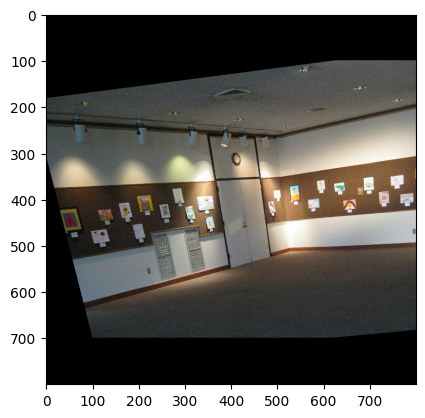

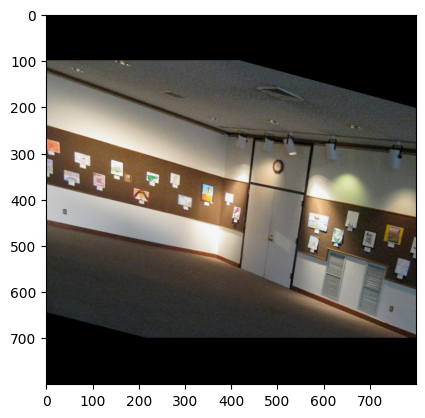

In [18]:
for i in range(0, 10):
    image, mask = next(iter(train_dataloader))

    image = image.numpy().squeeze(axis=0)
    plt.figure()
    plt.imshow(image)

(800, 800, 3)